In [1]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

### Imports

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
import pandas as pd 
import numpy as np 

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Flatten, GlobalAveragePooling1D, Dropout,GRU
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import nltk
import re
from nltk.corpus import stopwords
from textblob import Word

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

### Load Dataset

In [4]:
train_df = pd.read_csv('/content/train.tsv', sep='\t', header=0)

In [5]:
train_df.head()

,id,label,statement,subject,speaker,job,state,party,btc,fc,htc,mtc,pfc,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [6]:
train_df = train_df[['statement','label']]

In [7]:
for index in range(len(train_df['label'])):
     if(train_df.iloc[index]['label'] == 'true' or train_df.iloc[index]['label'] == 'mostly-true' or train_df.iloc[index]['label'] == 'half-true'):
       train_df.iloc[index]['label'] = 'true'
      
     if(train_df.iloc[index]['label'] == 'barely-true' or train_df.iloc[index]['label'] == 'false' or train_df.iloc[index]['label'] == 'pants-fire'):
       train_df.iloc[index]['label'] = 'false'

In [8]:
train_df.head()

,statement,label
0,Says the Annies List political group supports ...,false
1,When did the decline of coal start? It started...,true
2,"Hillary Clinton agrees with John McCain ""by vo...",true
3,Health care reform legislation is likely to ma...,false
4,The economic turnaround started at the end of ...,true


In [9]:
rslt_df = train_df[train_df['label'] == 'true']
rslt_df['label'] = 1
fslt_df = train_df[train_df['label'] == 'false']
fslt_df['label'] = 0
frames = [fslt_df, rslt_df]
train_df = pd.concat(frames)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [10]:
train_df = train_df[train_df['statement'].notnull()]
train_df

,statement,label
0,Says the Annies List political group supports ...,0
3,Health care reform legislation is likely to ma...,0
6,Jim Dunnam has not lived in the district he re...,0
12,When Mitt Romney was governor of Massachusetts...,0
14,Most of the (Affordable Care Act) has already ...,0
...,...,...
10232,Eighty percent of the net new jobs created in ...,1
10234,"Under the ruling of the Supreme Court, any lob...",1
10235,There are a larger number of shark attacks in ...,1
10236,Democrats have now become the party of the [At...,1


### Data Preprocessing

In [13]:
train_df["statement"]=train_df["statement"].apply(lambda x: " ".join(x.lower() for x in x.split()))
train_df["statement"]=train_df["statement"].str.replace('[^\w\s]', '').replace('\d', '')

sw=stopwords.words('english')
train_df["statement"]=train_df["statement"].apply(lambda x: " ".join(x for x in x.split() if x not in sw))
train_df["statement"]=train_df["statement"].apply(lambda x:" ".join([Word(word).lemmatize() for word in x.split()]))

train_df.tail()

,statement,label
10232,eighty percent net new job created state texas...,1
10234,ruling supreme court lobbyist could go legisla...,1
10235,larger number shark attack florida case voter ...,1
10236,democrat become party atlanta metro area black,1
10237,say alternative social security operates galve...,1


# Normal Embeddings

### Splitting Data

In [14]:
X_train, X_test, y_train, y_test = train_test_split(train_df['statement'],train_df['label'], test_size=0.2, random_state=111)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(8192,) (8192,) (2048,) (2048,)


### Tokenizing

In [15]:
vocab_size = 10000
oov_token = "<OOV>"
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)

tokenizer.fit_on_texts(X_train)

In [16]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [17]:
max_length = 120
trunc_type = 'post'
pad_type = 'post'

X_train_padded = pad_sequences(X_train, maxlen=max_length, truncating=trunc_type, padding=pad_type)
X_test_padded = pad_sequences(X_test, maxlen=max_length, truncating=trunc_type, padding=pad_type)

In [18]:
print(X_train_padded.shape, X_test_padded.shape)

(8192, 120) (2048, 120)


In [19]:
print(type(X_train_padded), type(X_test_padded))
print(type(y_train), type(y_test))
y_train = np.array(y_train)
y_test = np.array(y_test)
print(type(X_train_padded), type(X_test_padded))
print(type(y_train), type(y_test))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


### Model Creation

In [20]:
embedding_dim = 300

In [21]:
model = Sequential()
# define CNN model
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=8, activation='relu'))
#model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
# define LSTM model
model.add(GRU(32, return_sequences=True))
#model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(32, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 300)          3000000   
                                                                 
 conv1d (Conv1D)             (None, 113, 32)           76832     
                                                                 
 gru (GRU)                   (None, 113, 32)           6336      
                                                                 
 flatten (Flatten)           (None, 3616)              0         
                                                                 
 dense (Dense)               (None, 32)                115744    
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,198,945
Trainable params: 3,198,945
Non-

### Model Compilation

In [23]:
optimizer = tf.keras.optimizers.Adam(lr = 0.0001)
model.compile(
    loss = "binary_crossentropy",
    optimizer = optimizer,
    metrics = ["accuracy"]
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [24]:
filepath = 'my_checkpoint.ckpt'
cp = ModelCheckpoint(
    filepath=filepath,
    save_weights_only=True,
    save_best_only=True,
    monitor='val_accuracy',
    verbose=1
)

In [25]:
ep = EarlyStopping(
    monitor='val_accuracy', 
    patience=7,
)

### Model Training

In [26]:
epochs=25
history = model.fit(
    X_train_padded, y_train,
    validation_split = 0.2,
    callbacks=[cp,ep],
    batch_size=128,
    epochs=epochs
)

Epoch 1/25
52/52 [==============================] - ETA: 0s - loss: 0.6876 - accuracy: 0.5510
Epoch 00001: val_accuracy improved from -inf to 0.55949, saving model to my_checkpoint.ckpt
52/52 [==============================] - 16s 65ms/step - loss: 0.6876 - accuracy: 0.5510 - val_loss: 0.6859 - val_accuracy: 0.5595
Epoch 2/25
51/52 [============================>.] - ETA: 0s - loss: 0.6865 - accuracy: 0.5544
Epoch 00002: val_accuracy did not improve from 0.55949
52/52 [==============================] - 2s 38ms/step - loss: 0.6865 - accuracy: 0.5544 - val_loss: 0.6853 - val_accuracy: 0.5595
Epoch 3/25
51/52 [============================>.] - ETA: 0s - loss: 0.6829 - accuracy: 0.5545
Epoch 00003: val_accuracy did not improve from 0.55949
52/52 [==============================] - 2s 34ms/step - loss: 0.6830 - accuracy: 0.5542 - val_loss: 0.6830 - val_accuracy: 0.5595
Epoch 4/25
51/52 [============================>.] - ETA: 0s - loss: 0.6634 - accuracy: 0.5797
Epoch 00004: val_accuracy impro

### Graphs

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


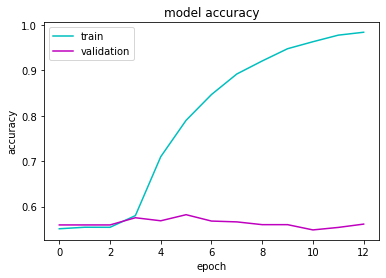

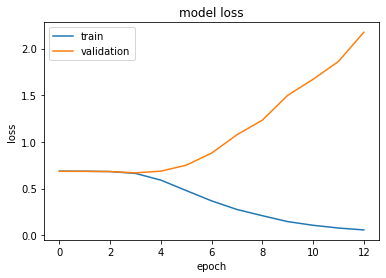

In [29]:
print(history.history.keys())
plt.axes().set(facecolor ="white")
plt.plot(history.history['accuracy'],color='c')
plt.plot(history.history['val_accuracy'],color='m')
plt.title('model accuracy').set_color('black')
plt.ylabel('accuracy').set_color('black')
plt.xlabel('epoch').set_color('black')
plt.legend(['train', 'validation'], loc='upper left')

plt.show()

plt.axes().set(facecolor ="white")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'validation'], loc='upper left')
plt.title('model loss').set_color('black')
plt.ylabel('loss').set_color('black')
plt.xlabel('epoch').set_color('black')
plt.show()

### Model Evaluation

In [30]:
model.evaluate(X_test_padded, y_test)

64/64 [==============================] - 2s 12ms/step - loss: 2.1862 - accuracy: 0.5752


[2.186184883117676, 0.5751953125]

### Predicting Test Data

In [31]:
predictions = (model.predict(X_test_padded) > 0.5).astype("int32")

### Accuracy

In [32]:
accuracy = accuracy_score(y_test, predictions)
print("Testing Accuracy: ", accuracy)

Testing Accuracy:  0.5751953125


### Confusion Matrix

Confusion Matrix
AxesSubplot(0.125,0.125;0.62x0.755)
              precision    recall  f1-score   support

           0    0.48286   0.39953   0.43726       846
           1    0.62315   0.69884   0.65882      1202

    accuracy                        0.57520      2048
   macro avg    0.55300   0.54918   0.54804      2048
weighted avg    0.56519   0.57520   0.56730      2048



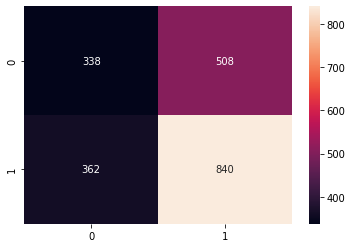

In [33]:
print('Confusion Matrix')
cm = confusion_matrix(y_test, predictions)
print(sns.heatmap(confusion_matrix(y_test, predictions),annot=True,fmt="d"))
print(classification_report(y_test, predictions, digits=5))

### Predicting new tweets

In [34]:
def preprocess_tweet(new_tweet):    
    new_tweet = new_tweet.lower()
    new_tweet = re.sub('[^\w\s]', '', new_tweet)
    new_tweet = re.sub('\d', '', new_tweet)

    new_tweet = " ".join(x for x in new_tweet.split() if x not in sw)
    new_tweet = " ".join([Word(word).lemmatize() for word in new_tweet.split()])
    print("On processing::", new_tweet)
    
    tokenizer.fit_on_texts(new_tweet)

    new_tweet = tokenizer.texts_to_sequences([new_tweet])

    new_tweet =  pad_sequences(new_tweet, maxlen=max_length, truncating=trunc_type, padding=pad_type)

    return new_tweet

def predict_newTweet(tweet):
    print("Input Tweet: ", tweet)
    emb_tweet = preprocess_tweet(tweet)
    result =  (model.predict(emb_tweet) > 0.5).astype("int32")
#     print(result)
    print("Output: " + "Real News" if result[0][0] == 1 else "Fake News")


In [36]:
new_tweet = "Fires start in apartment buildings in Chicago; injuring 20 civilians #CNN"
predict_newTweet(new_tweet)

Input Tweet:  Fires start in apartment buildings in Chicago; injuring 20 civilians #CNN
On processing:: fire start apartment building chicago injuring civilian cnn
Output: Real News


In [37]:
new_tweet = "Supreme cour has provided a new order which states an alternative to democrats"
predict_newTweet(new_tweet)

Input Tweet:  Supreme cour has provided a new order which states an alternative to democrats
On processing:: supreme cour provided new order state alternative democrat
Output: Real News


In [35]:
new_tweet = "Tomorrow is a holiday"
predict_newTweet(new_tweet)

Input Tweet:  Tomorrow is a holiday
On processing:: tomorrow holiday
Fake News


# Word2Vec Exploration

In [38]:
import gensim
X = [d.split() for d in train_df['statement'].tolist()]
DIM = 300
w2v_model = gensim.models.Word2Vec(sentences = X, size = DIM, window = 10, min_count = 1)
#w2v_model = gensim.models.FastText(sentences = X, size = DIM, window = 10, min_count = 1)

In [39]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

In [40]:
X = tokenizer.texts_to_sequences(X)

In [41]:
X = pad_sequences(X, maxlen = 120)
vocab_size = len(tokenizer.word_index) + 1

In [42]:
vocab = tokenizer.word_index
def get_weight_matrix(model):
    weight_matrix = np.zeros((vocab_size, DIM))

    for word, i in vocab.items():
        weight_matrix[i] = model.wv[word]

    return weight_matrix

In [43]:
embedding_vectors = get_weight_matrix(w2v_model)
embedding_vectors.shape
max_length = 120

In [44]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Flatten
model = Sequential()
model.add(Embedding(vocab_size, output_dim = DIM, weights = [embedding_vectors], input_length = max_length, trainable = True))
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=8, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
#model.add(GRU(32, return_sequences=True))
model.add(Bidirectional(GRU(32, return_sequences=True)))
#model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(32, activation="relu"))
#model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X,train_df['label'], test_size=0.2, random_state=111)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(8192, 120) (8192,) (2048, 120) (2048,)


In [46]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(loss = "binary_crossentropy",optimizer = optimizer,metrics = ["accuracy"])
filepath = 'my_checkpoint.ckpt'
cp = ModelCheckpoint(filepath=filepath,save_weights_only=True,save_best_only=True,monitor='val_accuracy',verbose=1)
ep = EarlyStopping(monitor='val_accuracy', patience=7,)

In [47]:
epochs=25
history = model.fit(
    X_train, y_train,
    validation_split = 0.2,
    callbacks=[cp,ep],
    batch_size=128,
    epochs=epochs
)

Epoch 1/25
52/52 [==============================] - ETA: 0s - loss: 0.6864 - accuracy: 0.5538
Epoch 00001: val_accuracy improved from -inf to 0.55949, saving model to my_checkpoint.ckpt
52/52 [==============================] - 7s 64ms/step - loss: 0.6864 - accuracy: 0.5538 - val_loss: 0.6850 - val_accuracy: 0.5595
Epoch 2/25
51/52 [============================>.] - ETA: 0s - loss: 0.6845 - accuracy: 0.5562
Epoch 00002: val_accuracy improved from 0.55949 to 0.56071, saving model to my_checkpoint.ckpt
52/52 [==============================] - 2s 41ms/step - loss: 0.6846 - accuracy: 0.5559 - val_loss: 0.6848 - val_accuracy: 0.5607
Epoch 3/25
51/52 [============================>.] - ETA: 0s - loss: 0.6829 - accuracy: 0.5571
Epoch 00003: val_accuracy improved from 0.56071 to 0.56315, saving model to my_checkpoint.ckpt
52/52 [==============================] - 2s 41ms/step - loss: 0.6829 - accuracy: 0.5568 - val_loss: 0.6843 - val_accuracy: 0.5631
Epoch 4/25
51/52 [============================

In [48]:
model.evaluate(X_test, y_test)

64/64 [==============================] - 1s 9ms/step - loss: 1.2564 - accuracy: 0.5293


[1.256399393081665, 0.529296875]

In [49]:
predictions = (model.predict(X_test) > 0.5).astype("int32")
accuracy = accuracy_score(y_test, predictions)
print("Testing Accuracy: ", accuracy)

Testing Accuracy:  0.529296875


Confusion Matrix
AxesSubplot(0.125,0.125;0.62x0.755)
              precision    recall  f1-score   support

           0    0.45227   0.66076   0.53698       846
           1    0.64655   0.43677   0.52135      1202

    accuracy                        0.52930      2048
   macro avg    0.54941   0.54876   0.52917      2048
weighted avg    0.56629   0.52930   0.52781      2048



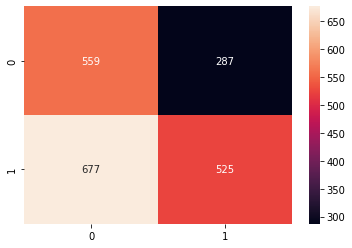

In [50]:
print('Confusion Matrix')
cm = confusion_matrix(y_test, predictions)
print(sns.heatmap(confusion_matrix(y_test, predictions),annot=True,fmt="d"))
print(classification_report(y_test, predictions, digits=5))

# Glove Exploration

In [51]:
X_train, X_test, y_train, y_test = train_test_split(train_df['statement'],train_df['label'], test_size=0.2, random_state=111)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(8192,) (8192,) (2048,) (2048,)


In [52]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
words_to_index = tokenizer.word_index

In [53]:
def read_glove_vector(glove_vec):
  with open(glove_vec, 'r', encoding='UTF-8') as f:
    words = set()
    word_to_vec_map = {}
    for line in f:
      w_line = line.split()
      curr_word = w_line[0]
      word_to_vec_map[curr_word] = np.array(w_line[1:], dtype=np.float64)

  return word_to_vec_map

In [54]:
word_to_vec_map = read_glove_vector('/content/drive/MyDrive/a_fake_news_detection/glove.6B.50d.txt')
maxLen = 120

In [55]:
vocab_len = len(words_to_index) + 1
embed_vector_len = word_to_vec_map['moon'].shape[0]
emb_matrix = np.zeros((vocab_len, embed_vector_len))

In [56]:
for word, index in words_to_index.items():
  embedding_vector = word_to_vec_map.get(word)
  if embedding_vector is not None:
    emb_matrix[index, :] = embedding_vector

In [57]:
X_train_padded = tokenizer.texts_to_sequences(X_train)
X_train_padded = pad_sequences(X_train_padded, maxlen=maxLen, padding='post')
X_test_padded = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_padded, maxlen=maxLen, padding='post')

In [59]:
model = Sequential()
# define CNN model
#model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(Embedding(input_dim=vocab_len, output_dim=embed_vector_len, input_length=120, weights = [emb_matrix], trainable=True))
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=8, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
# define LSTM model
model.add(Bidirectional(GRU(32, return_sequences=True)))
#model.add(GRU(32, return_sequences=True))
#model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(32, activation="relu"))
#model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))

In [60]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(loss = "binary_crossentropy",optimizer = optimizer,metrics = ["accuracy"])
filepath = 'my_checkpoint.ckpt'
cp = ModelCheckpoint(filepath=filepath,save_weights_only=True,save_best_only=True,monitor='val_accuracy',verbose=1)
ep = EarlyStopping(monitor='val_accuracy', patience=7)

In [61]:
epochs=25
history = model.fit(
    X_train_padded, y_train,
    validation_split = 0.2,
    callbacks=[cp,ep],
    batch_size=128,
    epochs=epochs
)

Epoch 1/25
52/52 [==============================] - ETA: 0s - loss: 0.6827 - accuracy: 0.5590
Epoch 00001: val_accuracy improved from -inf to 0.56071, saving model to my_checkpoint.ckpt
52/52 [==============================] - 7s 53ms/step - loss: 0.6827 - accuracy: 0.5590 - val_loss: 0.6826 - val_accuracy: 0.5607
Epoch 2/25
51/52 [============================>.] - ETA: 0s - loss: 0.6756 - accuracy: 0.5761
Epoch 00002: val_accuracy improved from 0.56071 to 0.57657, saving model to my_checkpoint.ckpt
52/52 [==============================] - 2s 32ms/step - loss: 0.6755 - accuracy: 0.5764 - val_loss: 0.6788 - val_accuracy: 0.5766
Epoch 3/25
51/52 [============================>.] - ETA: 0s - loss: 0.6699 - accuracy: 0.5953
Epoch 00003: val_accuracy did not improve from 0.57657
52/52 [==============================] - 2s 32ms/step - loss: 0.6699 - accuracy: 0.5953 - val_loss: 0.6755 - val_accuracy: 0.5723
Epoch 4/25
51/52 [============================>.] - ETA: 0s - loss: 0.6646 - accuracy:

In [62]:
model.evaluate(X_test_padded, y_test)

64/64 [==============================] - 2s 11ms/step - loss: 0.6748 - accuracy: 0.5894


[0.6747572422027588, 0.58935546875]

In [63]:
predictions = (model.predict(X_test_padded) > 0.5).astype("int32")
accuracy = accuracy_score(y_test, predictions)
print("Testing Accuracy: ", accuracy)

Testing Accuracy:  0.58935546875


Confusion Matrix
AxesSubplot(0.125,0.125;0.62x0.755)
              precision    recall  f1-score   support

           0    0.50368   0.40426   0.44852       846
           1    0.63185   0.71963   0.67289      1202

    accuracy                        0.58936      2048
   macro avg    0.56776   0.56194   0.56071      2048
weighted avg    0.57890   0.58936   0.58021      2048



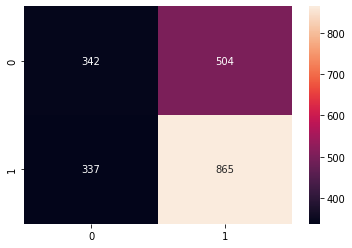

In [64]:
print('Confusion Matrix')
cm = confusion_matrix(y_test, predictions)
print(sns.heatmap(confusion_matrix(y_test, predictions),annot=True,fmt="d"))
print(classification_report(y_test, predictions, digits=5))

# BERT Explore

In [65]:
X_train, X_test, y_train, y_test = train_test_split(train_df['statement'],train_df['label'], test_size=0.2, random_state=111)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(8192,) (8192,) (2048,) (2048,)


In [66]:
bert_abstract = ""
for sent in X_train:
    bert_abstract += sent +" "

len(bert_abstract)

622854

In [67]:
!pip install transformers -U

     |████████████████████████████████| 3.4 MB 10.7 MB/s 
     |████████████████████████████████| 596 kB 27.4 MB/s 
     |████████████████████████████████| 61 kB 410 kB/s 
     |████████████████████████████████| 895 kB 39.0 MB/s 
     |████████████████████████████████| 3.3 MB 24.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [68]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertModel.from_pretrained('bert-base-uncased')
input_ids = tf.constant(tokenizer.encode(bert_abstract))[None, :6000]
outputs = model(input_ids)
last_hidden_states = outputs[0]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
Token indices sequence length is longer than the specified maximum sequence length for this model (102196 > 512). Running this sequence through the model will resu

In [69]:
import numpy as np
emb_matrix = np.array(last_hidden_states)
emb_matrix = emb_matrix[0]
print(emb_matrix.shape)

(6000, 768)


In [70]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
words_to_index = tokenizer.word_index

In [71]:
maxLen = 120
X_train_padded = tokenizer.texts_to_sequences(X_train)
X_train_padded = pad_sequences(X_train_padded, maxlen=maxLen, padding='post')
X_test_padded = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_padded, maxlen=maxLen, padding='post')

In [72]:
model = Sequential()
# define CNN model
#model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(Embedding(input_dim=6000, output_dim=768, input_length=120, weights = [emb_matrix], trainable=True))
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=8, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(Bidirectional(GRU(32, return_sequences=True)))
#model.add(GRU(32, return_sequences=True))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))

In [73]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(loss = "binary_crossentropy",optimizer = optimizer,metrics = ["accuracy"])
filepath = 'my_checkpoint.ckpt'
cp = ModelCheckpoint(filepath=filepath,save_weights_only=True,save_best_only=True,monitor='val_accuracy',verbose=1)
ep = EarlyStopping(monitor='val_accuracy', patience=7)

In [74]:
epochs=25
history = model.fit(
    X_train_padded, y_train,
    validation_split = 0.2,
    callbacks=[cp,ep],
    batch_size=128,
    epochs=epochs
)

Epoch 1/25
52/52 [==============================] - ETA: 0s - loss: 0.6909 - accuracy: 0.5430
Epoch 00001: val_accuracy improved from -inf to 0.55949, saving model to my_checkpoint.ckpt
52/52 [==============================] - 9s 87ms/step - loss: 0.6909 - accuracy: 0.5430 - val_loss: 0.6856 - val_accuracy: 0.5595
Epoch 2/25
51/52 [============================>.] - ETA: 0s - loss: 0.6847 - accuracy: 0.5524
Epoch 00002: val_accuracy did not improve from 0.55949
52/52 [==============================] - 3s 54ms/step - loss: 0.6847 - accuracy: 0.5529 - val_loss: 0.6871 - val_accuracy: 0.5577
Epoch 3/25
51/52 [============================>.] - ETA: 0s - loss: 0.6822 - accuracy: 0.5553
Epoch 00003: val_accuracy did not improve from 0.55949
52/52 [==============================] - 3s 55ms/step - loss: 0.6825 - accuracy: 0.5547 - val_loss: 0.6869 - val_accuracy: 0.5595
Epoch 4/25
51/52 [============================>.] - ETA: 0s - loss: 0.6829 - accuracy: 0.5565
Epoch 00004: val_accuracy improv

In [75]:
model.evaluate(X_test_padded, y_test)

64/64 [==============================] - 3s 20ms/step - loss: 0.9861 - accuracy: 0.5815


In [76]:
predictions = (model.predict(X_test_padded) > 0.5).astype("int32")

Confusion Matrix
AxesSubplot(0.125,0.125;0.62x0.755)
              precision    recall  f1-score   support

           0    0.49134   0.36879   0.42134       846
           1    0.62208   0.73128   0.67228      1202

    accuracy                        0.58154      2048
   macro avg    0.55671   0.55004   0.54681      2048
weighted avg    0.56807   0.58154   0.56862      2048



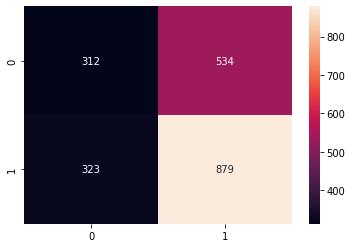

In [77]:
print('Confusion Matrix')
cm = confusion_matrix(y_test, predictions)
print(sns.heatmap(confusion_matrix(y_test, predictions),annot=True,fmt="d"))
print(classification_report(y_test, predictions, digits=5))